In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
%run setup.py
sns.set(style='darkgrid')

In [2]:
def simulate_fake_vix(VIXPARAS, start_date, end_date):
    """
    Simulates OU process following 
    dx_t = kappa * (mu - x_t) dt + sigma * dW_t
    """
    x0 = VIXPARAS['vix0']
    kappa = VIXPARAS['kappa']
    sigma = VIXPARAS['sigma']
    mu = VIXPARAS['mu']
    
    time_grid = pd.date_range(start=start_date, end=end_date, freq='D').to_pydatetime()
    
    M = len(time_grid)
    path = np.zeros(M)
    path[0] = x0
    rand = np.random.standard_normal(M-1)
    day_count = 365
    dt = 1 / day_count
        
    for t in range(1, len(time_grid)):
        path[t] = path[t-1] + kappa * (mu - path[t-1]) * dt \
                + sigma * np.sqrt(dt) * rand[t - 1]
    return pd.DataFrame(path, time_grid, columns=['fake_ts1'])  

In [4]:
exps = ['Permute=False_VIX=False',
       'Permute=False_VIX=True',
       'Permute=True_VIX=False',
       'Permute=True_VIX=True']
df_res = pd.DataFrame(columns=exps, index=['LR', 'ANN'])

In [5]:
df = pd.read_csv(data_dir + 'owid-covid-data.csv',
    usecols=['date', 'iso_code', 'continent', 'location','new_cases_per_million','new_deaths_per_million'],
    parse_dates=['date']
)
df = df.dropna()
european_union = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 
    'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']
df = df.loc[df.location.isin(european_union)]
# we calculate various previous days' average.
df = df.set_index('date')
cols = ['new_cases_per_million', 'new_deaths_per_million']
new_series = []

for c in cols:
    for d in [7, 14]:
        aux = df.groupby('iso_code')[c].rolling(f'{d}D', closed='left').mean()
        aux.name = f'{d}day_mean_{c}'
        new_series.append(aux)
    
df = df.reset_index().set_index(['iso_code', 'date']).join(new_series).reset_index()
df = df.dropna()

<AxesSubplot:>

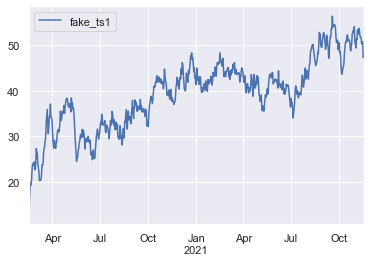

In [6]:
np.random.seed(143452)
VIXPARAS = {
    'vix0': 13,
    'kappa': 1,
    'sigma': 25,
    'mu': 15
}
fake_ts = simulate_fake_vix(VIXPARAS, start_date=df.date.min(), end_date=df.date.max())
df = df.join(fake_ts, on='date')
fake_ts.plot()

In [7]:
def adjusted_r_square(model, X, y):
    return 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)
feature_set = [
    '14day_mean_new_cases_per_million', 
    '7day_mean_new_deaths_per_million']
y = df[['new_deaths_per_million']]
for i in range(1, len(feature_set) + 1):
    X = df[feature_set[:i]]
    model = LinearRegression().fit(X, y)
    print(f'Use {i} feastures, adjusted R2 is {adjusted_r_square(model, X, y): .2}')

Use 1 feastures, adjusted R2 is  0.41
Use 2 feastures, adjusted R2 is  0.76


In [8]:
X = df[feature_set + ['fake_ts1']]
y = df[['new_deaths_per_million']]
seven_mean = df['7day_mean_new_deaths_per_million']
num_features = len(feature_set)

In [9]:
def fit_evaluate_lr(X_train, y_train, X_test, y_test):
    model = LinearRegression(fit_intercept=True).fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    return mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)

def fit_evaluate_ann(X_train, y_train, X_test, y_test, l2_alpha=1e-3, filepath=None):
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    input_shape = (X_train.shape[1], )
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(5, input_shape=input_shape, 
                                 kernel_regularizer=keras.regularizers.L2(l2_alpha)))
    model.add(keras.layers.Dense(5, kernel_regularizer=keras.regularizers.L2(l2_alpha)))
    model.add(keras.layers.Dense(1))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
    model.fit(x=X_train, y=y_train, epochs=100)
    model.save(filepath)
    return model.evaluate(X_train, y_train), model.evaluate(x=X_test, y=y_test)

def load_evaluate_ann(X_train, y_train, X_test, y_test, filepath=None, l2_alpha=None):
    model = keras.models.load_model(filepath)
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return model.evaluate(X_train, y_train), model.evaluate(X_test, y_test)

ann_func = fit_evaluate_ann if TRAIN_BY_YOURSELF else load_evaluate_ann

**Chronological split**

In [10]:
bl_train = (df['date'] < '2021-07-16').values
X_train = X.iloc[bl_train, :num_features]
y_train = y.loc[bl_train]

X_test = X.iloc[~bl_train, :num_features]
y_test = y.loc[~bl_train]

In [11]:
ckp_path = ckp_dir + 'Permute=False_VIX=False/model.h5'
lr_res = fit_evaluate_lr(X_train, y_train, X_test, y_test)
ann_res = ann_func(X_train, y_train, X_test, y_test, l2_alpha=1e-6, filepath=ckp_path)
baseline_benchmark = mean_squared_error(seven_mean.loc[~bl_train], y_test)

106/106 [==============================] - 0s 560us/step - loss: 4.2183


In [12]:
df_res.loc['LR', exps[0]] = (lr_res[1] - baseline_benchmark) / baseline_benchmark * 100
df_res.loc['ANN', exps[0]] = (ann_res[1] - baseline_benchmark) / baseline_benchmark * 100

**Chronological and fake ts**

In [13]:
X_train = X.loc[bl_train]
y_train = y.loc[bl_train]

X_test = X.loc[~bl_train]
y_test = y.loc[~bl_train]

In [14]:
ckp_path = ckp_dir + 'Permute=False_VIX=True/model.h5'
lr_res = fit_evaluate_lr(X_train, y_train, X_test, y_test)
ann_res = ann_func(X_train, y_train, X_test, y_test, l2_alpha=1e-6, filepath=ckp_path)
vix_benchmark = mean_squared_error(seven_mean.loc[~bl_train], y_test)

106/106 [==============================] - 0s 541us/step - loss: 4.2893


In [15]:
df_res.loc['LR', exps[1]] = (lr_res[1] - vix_benchmark) / vix_benchmark * 100
df_res.loc['ANN', exps[1]] = (ann_res[1] - vix_benchmark) / vix_benchmark * 100

**Random split**

In [16]:
num_iters = 10
test_size = X_test.shape[0] / df.shape[0]
print(f'{test_size * 100: .2f}% will be assigned to test set.')
X_train_set, X_test_set, y_train_set, y_test_set, seven_mean_train_set, seven_mean_test_set = [[] for _ in range(6)]

for i in range(num_iters):
    X_train, X_test, y_train, y_test, seven_train, seven_test = train_test_split(X, y, seven_mean, test_size=test_size, random_state=i)
    X_train_set.append(X_train)
    X_test_set.append(X_test)
    y_train_set.append(y_train)
    y_test_set.append(y_test)
    seven_mean_train_set.append(seven_train)
    seven_mean_test_set.append(seven_test)


 20.43% will be assigned to test set.


In [17]:
lr_train_mses, lr_test_mses, permute_benchmark_mses = [np.zeros((num_iters)) for _ in range(3)]
for i in range(num_iters):
    lr_train_mses[i], lr_test_mses[i] = fit_evaluate_lr(X_train_set[i].iloc[:, :num_features], y_train_set[i], X_test_set[i].iloc[:, :num_features], y_test_set[i])
    permute_benchmark_mses[i] = mean_squared_error(seven_mean_test_set[i], y_test_set[i])
    
ann_train_mses, ann_test_mses = [np.zeros((num_iters)) for _ in range(2)]
for i in range(num_iters):
    ckp_path = ckp_dir + f'Permute=True_VIX=False/model{i}.h5'
    ann_train_mses[i], ann_test_mses[i] = ann_func(X_train_set[i].iloc[:, :num_features], y_train_set[i], X_test_set[i].iloc[:, :num_features], y_test_set[i], l2_alpha=1e-5, filepath=ckp_path)

106/106 [==============================] - 0s 537us/step - loss: 6.1187


In [18]:
df_res.loc['LR', exps[2]] = (lr_test_mses.mean() - permute_benchmark_mses.mean()) / permute_benchmark_mses.mean() * 100
df_res.loc['ANN', exps[2]] = (ann_test_mses.mean() - permute_benchmark_mses.mean()) / permute_benchmark_mses.mean() * 100

In [33]:
rela_diff_permute = pd.DataFrame(index=['LR', 'ANN'], columns=range(num_iters))
rela_diff_permute.loc['LR'] = ((lr_test_mses - permute_benchmark_mses) / permute_benchmark_mses * 100 - df_res.loc['LR', exps[0]]) 
rela_diff_permute.loc['ANN'] = ((ann_test_mses - permute_benchmark_mses) / permute_benchmark_mses * 100 - df_res.loc['LR', exps[0]])

**Random split and fake ts**

In [36]:
lr_train_mses, lr_test_mses = [np.zeros((num_iters)) for _ in range(2)]
for i in range(num_iters):
    lr_train_mses[i], lr_test_mses[i] = fit_evaluate_lr(X_train_set[i], y_train_set[i], X_test_set[i], y_test_set[i])

ann_train_mses, ann_test_mses = [np.zeros((num_iters)) for _ in range(2)]
for i in range(num_iters):
    ckp_path = ckp_dir + f'Permute=True_VIX=True/model{i}.h5'
    ann_train_mses[i], ann_test_mses[i] = ann_func(X_train_set[i], y_train_set[i], X_test_set[i], y_test_set[i], l2_alpha=1e-6, filepath=ckp_path)

106/106 [==============================] - 0s 522us/step - loss: 6.1215


In [37]:
df_res.loc['LR', exps[3]] = (lr_test_mses.mean() - permute_benchmark_mses.mean()) / permute_benchmark_mses.mean() * 100
df_res.loc['ANN', exps[3]] = (ann_test_mses.mean() - permute_benchmark_mses.mean()) / permute_benchmark_mses.mean() * 100

In [38]:
rela_diff_permute_vix = pd.DataFrame(index=['LR', 'ANN'], columns=range(num_iters))
rela_diff_permute_vix.loc['LR'] = ((lr_test_mses - permute_benchmark_mses) / permute_benchmark_mses * 100 - df_res.loc['LR', exps[0]]) 
rela_diff_permute_vix.loc['ANN'] = ((ann_test_mses - permute_benchmark_mses) / permute_benchmark_mses * 100 - df_res.loc['LR', exps[0]])

Plotting

In [40]:
plot_kws = [('LR', 'x', -0.05, sns.color_palette()[0]),
       ('ANN', '^', 0.1, sns.color_palette()[1])]

Text(0.5, 1.0, 'COVID-19')

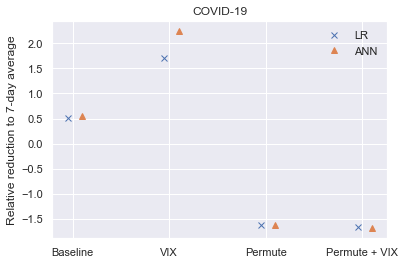

In [41]:
for row in plot_kws:
    plt.plot(np.arange(1, 5)+row[2], df_res.loc[row[0]], marker=row[1], linewidth=0, label=row[0], c=row[3])
plt.legend(frameon=False)
plt.xticks(np.arange(1, 5), ('Baseline', 'VIX', 'Permute', 'Permute + VIX'))
plt.ylabel('Relative reduction to 7-day average')
plt.title('COVID-19')
plt.savefig(res_dir + 'Figure3_left.png', dpi=100)

Text(0.5, 1.0, 'COVID-19')

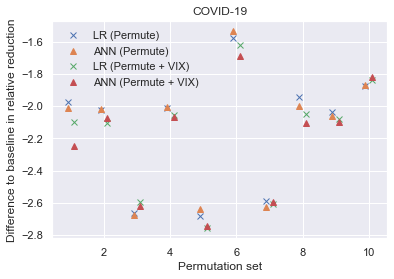

In [56]:
plot_kws = [('LR', 'x', -0.1, 'LR (Permute)'), ('ANN', '^', -0.1, 'ANN (Permute)')]
for row in plot_kws:
    plt.plot(np.arange(1, 1+num_iters)+row[2], rela_diff_permute.loc[row[0]], marker=row[1], linewidth=0, label=row[3])
plot_kws = [('LR', 'x', 0.1, 'LR (Permute + VIX)'), ('ANN', '^', 0.1, 'ANN (Permute + VIX)')]
for row in plot_kws:
    plt.plot(np.arange(1, 1+num_iters)+row[2], rela_diff_permute_vix.loc[row[0]], marker=row[1], linewidth=0, label=row[3])
plt.legend(frameon=False)
plt.xlabel('Permutation set')
plt.ylabel('Difference to baseline in relative reduction')
plt.title('COVID-19')
plt.savefig(res_dir + 'Figure3_right.png', dpi=100)